William Chambers

SID: 25912237

wachambers@berkeley.edu

In [1]:
%matplotlib inline
import scipy as sp
import scipy.io
import numpy as np
import sklearn
import pandas as pd
pd.options.display.mpl_style = 'default'
import matplotlib.pyplot as plt

# Problem 1

In [2]:
from sklearn.svm import LinearSVC

In [3]:
train = scipy.io.loadmat("data/digit-dataset/train.mat")
test = scipy.io.loadmat("data/digit-dataset/test.mat")

In [4]:
X = train['train_images'].T.reshape(60000,784)
y = train['train_labels'].reshape(60000,)
X_test_kaggle = test['test_images'].T.reshape(10000,784)
print(X.shape,y.shape) # make sure our shapes are good

(60000, 784) (60000,)


In [5]:
def train_test_split(X, y, train_size, test_size, random_state):
    np.random.seed(random_state)
    total = np.array(range(len(X)))
    np.random.shuffle(total)
    train_values = total[:train_size]
    test_values = total[train_size:train_size + test_size]
    X_train = X[train_values]
    y_train = y[train_values]
    X_validation = X[test_values]
    y_validation = y[test_values]
    assert len(set(train_values).intersection(set(test_values))) == 0
    return X_train, X_validation, y_train, y_validation

In [6]:
scoring = []
for amnt in [100, 200, 500, 1000, 2000, 5000, 10000]:
    clf = LinearSVC()
    X_train, X_validation, y_train, y_validation = train_test_split(
        X, y, test_size=10000, train_size=amnt, random_state=4100)
    clf.fit(X_train, y_train)
    skr = clf.score(X_validation, y_validation)
    scoring.append((amnt, skr))
    print("Completed Training of %i for mean score of %.2f." %(amnt, skr))

Completed Training of 100 for mean score of 0.64.
Completed Training of 200 for mean score of 0.68.
Completed Training of 500 for mean score of 0.71.
Completed Training of 1000 for mean score of 0.74.
Completed Training of 2000 for mean score of 0.73.
Completed Training of 5000 for mean score of 0.76.
Completed Training of 10000 for mean score of 0.80.


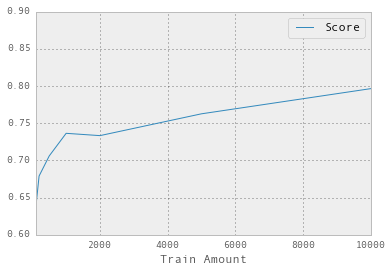

In [7]:
scores = pd.DataFrame(scoring)
scores.columns = ["Train Amount", "Score"]
scores.set_index('Train Amount', inplace=True)
scores.plot(ylim=(0.6,0.9))

# Problem 2

In [8]:
from sklearn.metrics import confusion_matrix
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(range(0,10)))
    plt.xticks(tick_marks, range(0,10), rotation=45)
    plt.yticks(tick_marks, range(0,10))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Completed Training of 100 for mean score of 0.64.
Completed Training of 200 for mean score of 0.68.
Completed Training of 500 for mean score of 0.71.
Completed Training of 1000 for mean score of 0.74.
Completed Training of 2000 for mean score of 0.73.
Completed Training of 5000 for mean score of 0.76.
Completed Training of 10000 for mean score of 0.80.


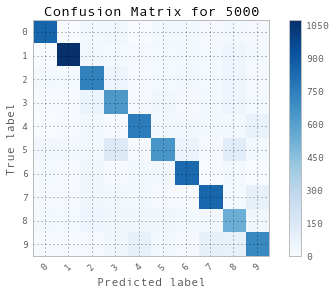

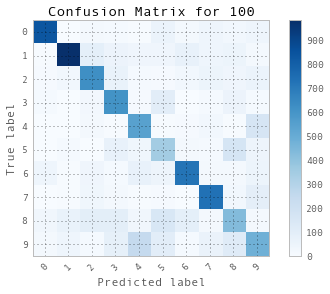

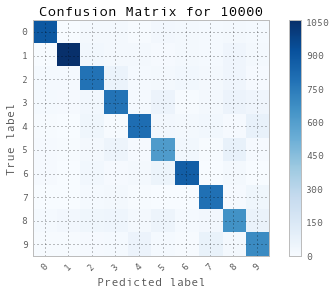

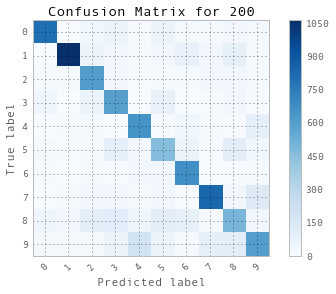

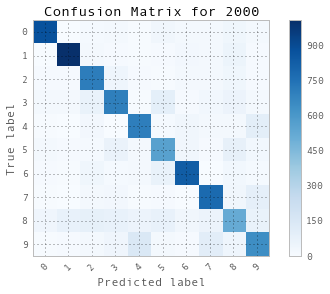

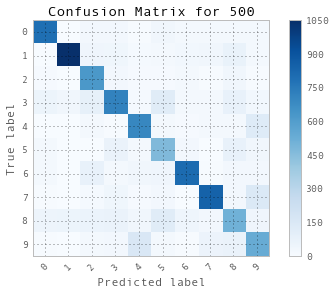

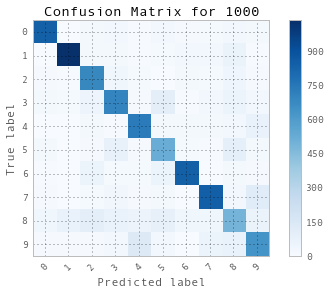

In [14]:
for amnt in [100, 200, 500, 1000, 2000, 5000, 10000]:
    clf = LinearSVC()
    X_train, X_validation, y_train, y_validation = train_test_split(
        X, y, test_size=10000, train_size=amnt, random_state=4100)
    clf.fit(X_train, y_train)
    skr = clf.score(X_validation, y_validation)
    y_pred = clf.predict(X_validation)
    print("Completed Training of %i for mean score of %.2f." %(amnt, skr))
    plot_confusion_matrix(confusion_matrix(y_pred, y_validation), "Confusion Matrix for %i" % amnt)
    plt.figure(amnt)

The confusion matrix gives us insight into where our algorithm is mis-classifying the data. More precisely, it allows us to see the classes that are most confused with one another. 

For example, with fewer training examples, classes `4` and `9` seem to often be confused. Later on, with more training examples, classes `5` and `8` seem to be confused a fair amount by our algorithm. A next focus might be to try and create features that might help differentiate these two classes further.

# Problem 3

Cross-validation is a technique that can help you with a number of issues in machine learning. Two of the more significant uses, and the ones we are taking advantage of here, are to help you avoid overfitting on the training set and to tune hyperparameters to get the most generalizable model.

We are going to use a technique called kfold cross validation to tackle the aforementioned challenges. By breaking up our training set into a set of folds, we are able to train and test on a variety of different samples. This ensures that we are not choosing a C value that is too representative of our training data and will not generalize well. If we see significant variance across the training and test folds, we're likely overfitting.

Cross validation helps ensure that our current model isn't overfitting to the training data, that our hyperparameters are good choices, and that the model will generalize well to new data - the true goal of any statistical/machine learning model.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, train_size=10000, random_state=4100)
# we're going to need a validation set

def kfolds(X, y, n_folds):
    chunk_size = len(X)/n_folds
    chunks = [(chunk_size * x, chunk_size * (x+1)) for x in range(n_folds)]
    for start, end in chunks:
        sub_X = np.concatenate([X[:start], X[end:]])
        sub_y = np.concatenate([y[:start], y[end:]])
        other_X = X[start:end]
        other_y = y[start:end]
        yield sub_X, sub_y, other_X, other_y

KFold cross validation also makes it easy to test across a parameter space, we just select potential values and iterate through them as I do below.

In [17]:
results = {}
for C in [1 * 10 ** x for x in range(-8, 1)]:
    clf = LinearSVC(C=C)
    scores = []
    print("C Value:", C)
    for count, (X_1, y_1, X_2, y_2) in enumerate(kfolds(X_train, y_train, 10)):
        clf.fit(X_1, y_1)
        score = clf.score(X_2, y_2)
        scores.append(score)
        # print("    Fold Number: %i, Score: %f" % (count, score))
    results[C] = scores
for k, v in sorted(results.items()):
    print("C Value of %f gives mean of %f and variance of %f." % (k, np.array(v).mean(), np.array(v).var()))

C Value: 1e-08
C Value: 1e-07
C Value: 1e-06
C Value: 1e-05
C Value: 0.0001
C Value: 0.001
C Value: 0.01
C Value: 0.1
C Value: 1
C Value of 0.000000 gives mean of 0.834500 and variance of 0.000074.
C Value of 0.000000 gives mean of 0.861500 and variance of 0.000107.
C Value of 0.000001 gives mean of 0.857900 and variance of 0.000097.
C Value of 0.000010 gives mean of 0.844500 and variance of 0.000113.
C Value of 0.000100 gives mean of 0.815900 and variance of 0.000133.
C Value of 0.001000 gives mean of 0.787600 and variance of 0.000186.
C Value of 0.010000 gives mean of 0.774700 and variance of 0.000425.
C Value of 0.100000 gives mean of 0.778000 and variance of 0.000209.
C Value of 1.000000 gives mean of 0.779800 and variance of 0.000362.


Based on this first cross-validation exercise, we can see that we've got a particular "sweet spot" in the range of  1e-07, 1e-06.

Due to this, I decided to see if I could hone in on an even better C value by performing cross validation again.

In [19]:
results2 = {}
for C in [x * 1e-07 for x in range(0,11,2)][1:]:
    clf = LinearSVC(C=C)
    scores = []
    print(C)
    for count, (X_1, y_1, X_2, y_2) in enumerate(kfolds(X_train, y_train, 10)):
        clf.fit(X_1, y_1)
        score = clf.score(X_2, y_2)
        scores.append(score)
        # print("    Fold Number: %i, Score: %f" % (count, score))
    results2[C] = scores
for k, v in sorted(results2.items()):
    print("C Value of %f gives mean of %f and variance of %f." % (k, np.array(v).mean(),np.array(v).var()))

2e-07
4e-07
6e-07
8e-07
1e-06
C Value of 0.000000 gives mean of 0.861400 and variance of 0.000117.
C Value of 0.000000 gives mean of 0.860900 and variance of 0.000067.
C Value of 0.000001 gives mean of 0.859800 and variance of 0.000090.
C Value of 0.000001 gives mean of 0.859100 and variance of 0.000106.
C Value of 0.000001 gives mean of 0.857900 and variance of 0.000097.


After running cross validation again, it became apparent that the best C value was 2e-07
. I now need to retrain the data in order to find the *validation error rate*. 

This error rate is calculated using a completely new set of data, the validation subset of the data. This is to, again, ensure that we're not overfitting to the data.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, train_size=10000, random_state=2100)

clf = LinearSVC(C=2e-07)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test_kaggle)

0.8638


From the above output we can see that the validation error that we have is 0.8638. This number describes how well our algorithm (and hyperparameter) has been able to generalize to new data. It also allows us to compare to the training that we performed in Problem 1. In comparing the two, we can see that we can converge to a local minima fairly easily, however modifying this parameter has given us a significantly better validation error than the one we had above. If we've tuned this parameter correctly, we should see a score similar to this on Kaggle.

In [22]:
res = pd.DataFrame(y_pred)
res[1] = res[0]
res[0] = range(len(y_pred))
res.columns = ["Id", "Category"]
res['Id'] = res['Id'] + 1
res.to_csv("digit_predict.csv", index=False)

# Problem 4

In [23]:
spam_data = scipy.io.loadmat("data/spam-dataset/spam_data.mat")

In [24]:
X = spam_data['training_data']
y = spam_data['training_labels'].reshape((5172,))
spam_test = spam_data['test_data']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, train_size=4172, random_state=4100)

In [26]:
results = {}
for C in [1 * 10 ** x for x in range(-8, 3)]:
    clf = LinearSVC(C=C)
    scores = []
    print("C Value: %.4f" % C)
    for count, (X_1, y_1, X_2, y_2) in enumerate(kfolds(X_train, y_train, 10)):
        clf.fit(X_1, y_1)
        score = clf.score(X_2, y_2)
        scores.append(score)
        # print("    Fold Number: %i, Score: %.4f" % (count, score))
    results[C] = scores
for k, v in sorted(results.items()):
    print("C Value of %f gives mean of %f and variance of %f." % (k, np.array(v).mean(),np.array(v).var()))

C Value: 0.0000
C Value: 0.0000
C Value: 0.0000
C Value: 0.0000
C Value: 0.0001
C Value: 0.0010
C Value: 0.0100
C Value: 0.1000
C Value: 1.0000
C Value: 10.0000
C Value: 100.0000
C Value of 0.000000 gives mean of 0.753113 and variance of 0.000440.
C Value of 0.000000 gives mean of 0.753353 and variance of 0.000457.
C Value of 0.000001 gives mean of 0.757189 and variance of 0.000431.
C Value of 0.000010 gives mean of 0.763659 and variance of 0.000397.
C Value of 0.000100 gives mean of 0.763901 and variance of 0.000383.
C Value of 0.001000 gives mean of 0.776129 and variance of 0.000491.
C Value of 0.010000 gives mean of 0.795786 and variance of 0.000443.
C Value of 0.100000 gives mean of 0.803933 and variance of 0.000306.
C Value of 1.000000 gives mean of 0.807530 and variance of 0.000370.
C Value of 10.000000 gives mean of 0.811123 and variance of 0.000291.
C Value of 100.000000 gives mean of 0.809221 and variance of 0.000626.


As I did above, I'm going to perform cross validation again to try and get a better C value.

In [27]:
results = {}
for C in [5 + (1/2 * x) for x in range(0,11)][1:]:
    clf = LinearSVC(C=C)
    scores = []
    print("C Value: %f" % C)
    for count, (X_1, y_1, X_2, y_2) in enumerate(kfolds(X_train, y_train, 10)):
        clf.fit(X_1, y_1)
        score = clf.score(X_2, y_2)
        scores.append(score)
        # print("    Fold Number: %i, Score: %f" % (count, score))
    results[C] = scores
for k, v in sorted(results.items()):
    print("C Value of %f gives mean of %f and variance of %f." % (k, np.array(v).mean(),np.array(v).var()))

C Value: 5.500000
C Value: 6.000000
C Value: 6.500000
C Value: 7.000000
C Value: 7.500000
C Value: 8.000000
C Value: 8.500000
C Value: 9.000000
C Value: 9.500000
C Value: 10.000000
C Value of 5.500000 gives mean of 0.809925 and variance of 0.000407.
C Value of 6.000000 gives mean of 0.811364 and variance of 0.000290.
C Value of 6.500000 gives mean of 0.806572 and variance of 0.000212.
C Value of 7.000000 gives mean of 0.812083 and variance of 0.000220.
C Value of 7.500000 gives mean of 0.812561 and variance of 0.000397.
C Value of 8.000000 gives mean of 0.811842 and variance of 0.000274.
C Value of 8.500000 gives mean of 0.811603 and variance of 0.000327.
C Value of 9.000000 gives mean of 0.810642 and variance of 0.000376.
C Value of 9.500000 gives mean of 0.809207 and variance of 0.000404.
C Value of 10.000000 gives mean of 0.811124 and variance of 0.000392.


In [34]:
clf = LinearSVC(C=7.25)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
y_pred = clf.predict(spam_test)

0.817


We can see that the best C value seemed to be we got was in between 7 and 7.5.

using that value, we can see that our validation error was 0.817.

I did not add or remove any features.

In [35]:
res = pd.DataFrame(y_pred)
res[1] = res[0]
res[0] = range(len(y_pred))
res.columns = ["Id", "Category"]
res['Id'] = res['Id'] + 1
res.to_csv("spam_predict.csv", index=False)

*You can rerun this in an ipython notebook, there are no unexpected dependencies - only those that are listed at the top of the file.*